In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.pyplot import rc_context
from scipy.stats import median_abs_deviation
import matplotlib.pyplot as plt

# Preprocessing

In [2]:
df = pd.read_csv('./Task 5/test_data.tsv', sep='\t', index_col=0)
df.head()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
6,1.501749,0.526060,3.523124,1.485025,4.788795,5.483128,-0.314870,1.000637,3.304998
7,0.848230,0.105850,4.921549,-1.726940,5.253668,0.333739,0.342336,5.876312,1.362900
11,1.546926,0.406637,4.981942,1.047433,5.358941,5.631640,0.155462,0.905064,4.506790
16,1.697505,0.291444,5.583107,4.706273,5.912384,0.882935,0.353881,5.494634,-1.550571
17,1.248090,0.245040,5.429337,2.404481,5.351980,3.329632,0.333889,1.306445,4.934134


In [3]:
df.shape

(34812, 9)

In [4]:
def is_outlier_by_mad (dataset : pd.DataFrame, col : str) :
    mad = median_abs_deviation(dataset[col])
    m_i = 0.6745 * (dataset[col] - dataset[col].median()) / mad
    return (m_i > 3.5)

def get_iqr_lower_bound (dataset : pd.DataFrame, col : str) :
    iqr = dataset[col].quantile(0.75) - dataset[col].quantile(0.25)
    lower_bound = dataset[col].quantile(0.25) - iqr * 1.5
    return lower_bound

def is_outlier_by_iqr_lower (dataset : pd.DataFrame, col : str) :
    iqr = dataset[col].quantile(0.75) - dataset[col].quantile(0.25)
    lower_bound = dataset[col].quantile(0.25) - iqr * 1.5
    return (dataset[col] < lower_bound)

def is_outlier_by_iqr (dataset : pd.DataFrame, col : str) :
    iqr = dataset[col].quantile(0.75) - dataset[col].quantile(0.25)
    lower_bound = dataset[col].quantile(0.25) - iqr * 1.5
    upper_bound = dataset[col].quantile(0.75) + iqr * 1.5
    return (dataset[col] < lower_bound) | (dataset[col] > upper_bound)

Сначала прочитаем датасет через pandas чтобы оценить распределения экспресий для каждого гена (маркера), а также forward и side scattering, чтобы исключить выбросы. Для этого построим boxplot и посмотим какие данные окажутся в верхнем и нижнем квартилях

<Axes: >

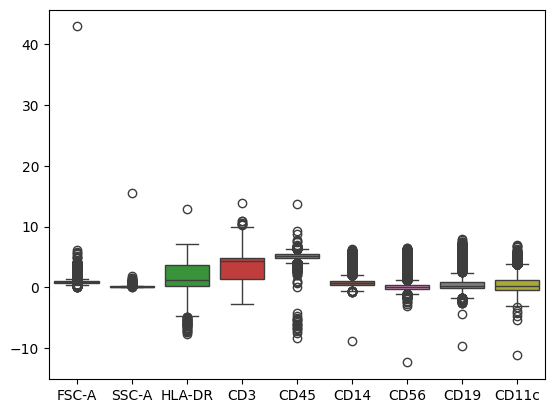

In [5]:
sns.boxplot(df)

Заметно, что forward scattering и side scattering имеет выброс сверху (около 40 и 15 соотвественно). Первый параметр позволяет оценить размеры клетки, а второй ее гранулярность. Мы видим, что данные клетки(а) имееют разительно отличающиеся размеры и гранлярность, что может исказить наш дальнейший анализ. Поэтому исключим данную клетку(и)

In [6]:
df.loc[(df['FSC-A'] > 40) & (df['SSC-A'] > 10)]

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
67325,42.954485,15.460997,12.946668,13.844391,13.710922,-8.833883,-12.358701,-9.640775,-11.085437


In [7]:
df.min(axis=0)

FSC-A      0.083477
SSC-A      0.004305
HLA-DR    -7.634172
CD3       -2.658754
CD45      -8.329666
CD14      -8.833883
CD56     -12.358701
CD19      -9.640775
CD11c    -11.085437
dtype: float64

Это оказался одна клетка. При том можно заметить, что она также имеет самые низкие значения по маркерам CD14-CD11c. Исключим ее из дальнейшего анализа

In [8]:
df = df.loc[(df['FSC-A'] < 40) & (df['SSC-A'] < 10)]
df.shape

(34811, 9)

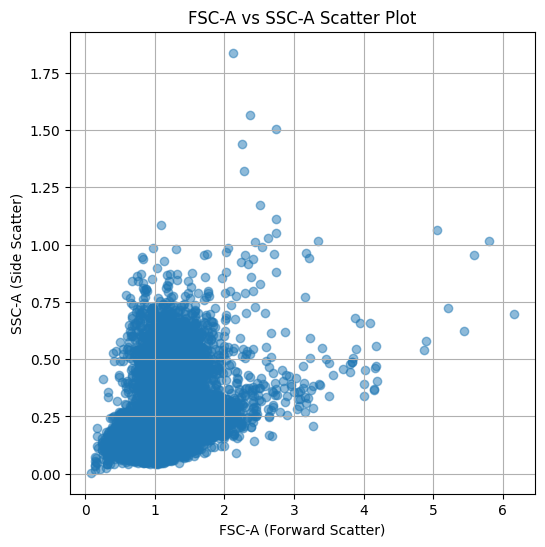

In [9]:
def plot_ssc_fsc(dataset, c=None):
    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(dataset['FSC-A'], dataset['SSC-A'], c=c, alpha=0.5)
    plt.title('FSC-A vs SSC-A Scatter Plot')
    plt.xlabel('FSC-A (Forward Scatter)')
    plt.ylabel('SSC-A (Side Scatter)')
    if (c != None):
        plt.colorbar(scatter, label='CD45')
    plt.grid(True)
    plt.show()
plot_ssc_fsc(df)

Из scatterplot видно, что есть клетки, являющиеся outliers сверху. Попробуем почистить по границе сверху (FSC-A <2.5, SSC-A <0.75). Попробуем также посмотреть на выбросы снизу, чтобы почистить данные от возможных мертвых клеток или мусора

<Axes: >

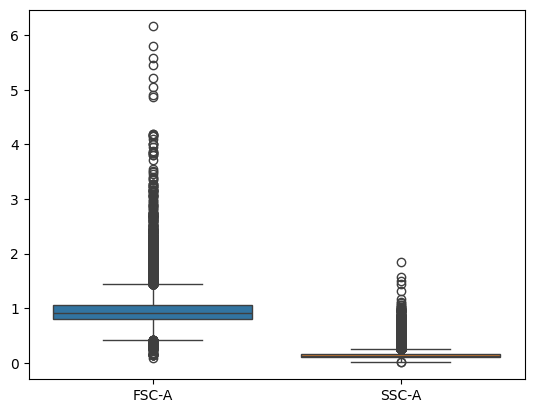

In [10]:
sns.boxplot(df.loc[:, ['FSC-A', 'SSC-A']])

Видно, что есть клетки, имеющие SSC-A очень близкое к нулю, что может означать, что внутри клетки малой внутриклеточной структур (органелл), поэтому это может означать, что это мертвые клетки или мусор. Проверим также forward scattering у них

In [11]:
df.loc[is_outlier_by_iqr_lower (df, 'SSC-A')]

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
131143,0.083477,0.004305,0.495193,3.484122,3.554754,0.546051,-0.153232,0.574519,0.035261
133262,0.143098,0.016761,-1.017599,-0.055147,3.548416,-0.114578,3.502444,0.397872,0.443828


In [12]:
df.min()

FSC-A     0.083477
SSC-A     0.004305
HLA-DR   -7.634172
CD3      -2.658754
CD45     -8.329666
CD14     -0.828496
CD56     -3.079160
CD19     -4.343011
CD11c    -5.400234
dtype: float64

Можно заметить, что эти две клетки имеют также очень низкий forward scaterring, что потверждает наши гипотезы, поэтому уберем и их

In [14]:
df = df.loc[~is_outlier_by_iqr_lower(df, 'FSC-A') & ~is_outlier_by_iqr_lower(df, 'SSC-A') 
                     & (df['SSC-A'] < 0.75) & (df['FSC-A'] < 2.3),:]
df.shape

(34464, 9)

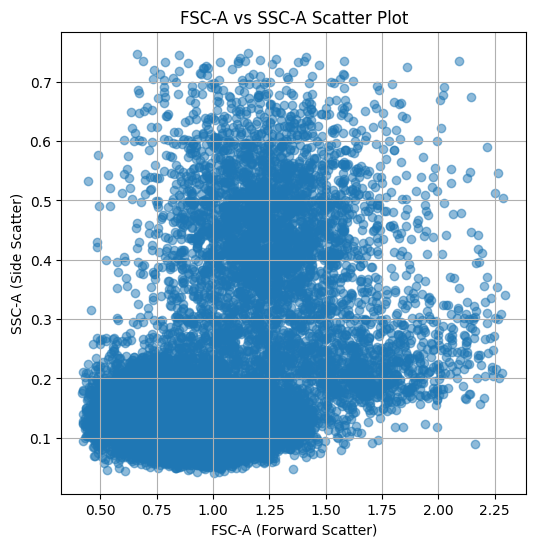

In [15]:
plot_ssc_fsc (df)

<Axes: >

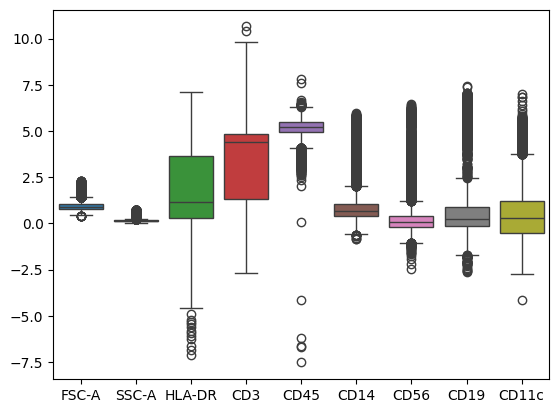

In [16]:
sns.boxplot(df)

Осталось почистить выбросы по маркерам, снизу, чтобы было меньше наблюдений, с отрицательными значениями интенсивности флуорестенции

In [17]:
df = df.loc[(df['CD45'] > 1) & ~is_outlier_by_iqr_lower(df, 'HLA-DR') &
                   ~is_outlier_by_iqr_lower(df, 'CD14') & ~is_outlier_by_iqr_lower(df, 'CD56') &
                   ~is_outlier_by_iqr_lower(df, 'CD19') & ~is_outlier_by_iqr_lower(df, 'CD11c')]
df.shape

(34323, 9)

In [208]:
df.loc[~is_outlier_by_mad(df, 'FSC-A')].shape

(33330, 9)

<Axes: >

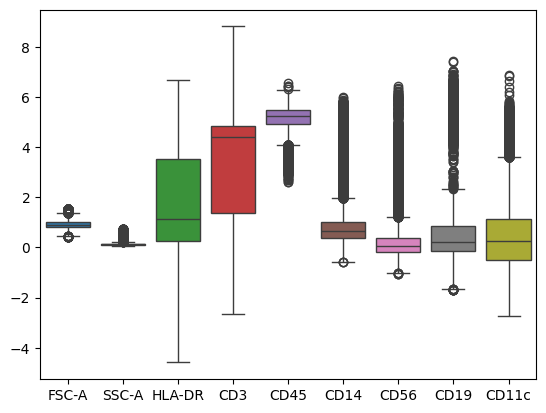

In [18]:
sns.boxplot(df.loc[~is_outlier_by_mad(df, 'FSC-A')])

Посмотрим на распределение экспресий

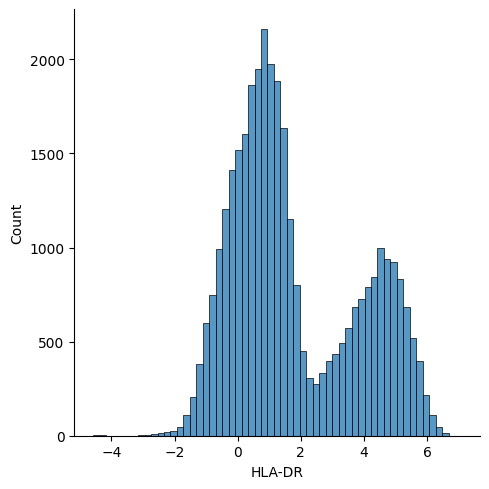

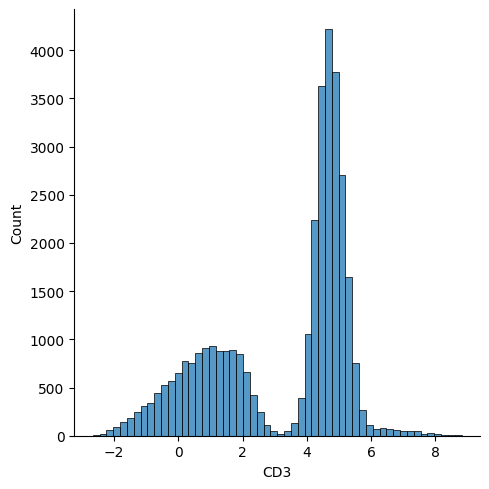

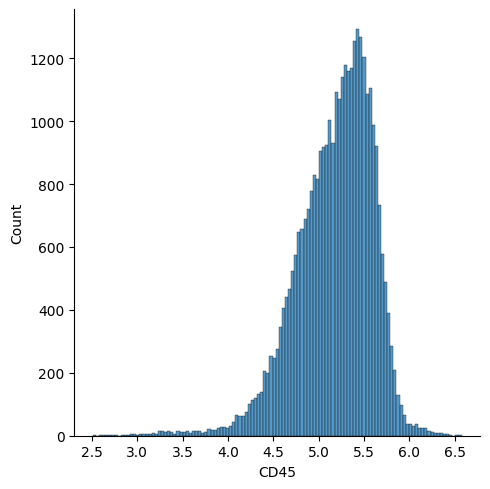

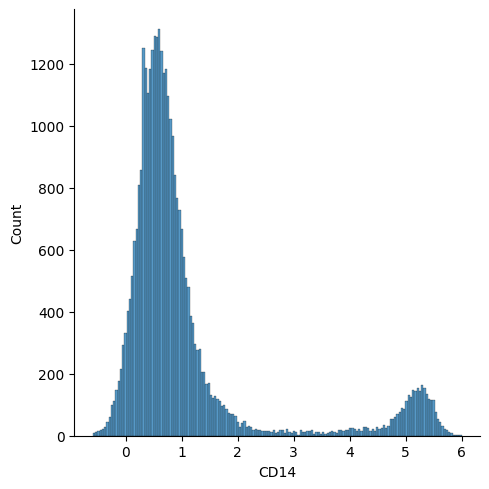

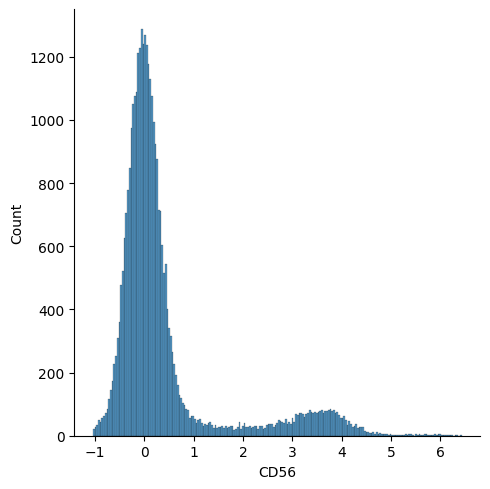

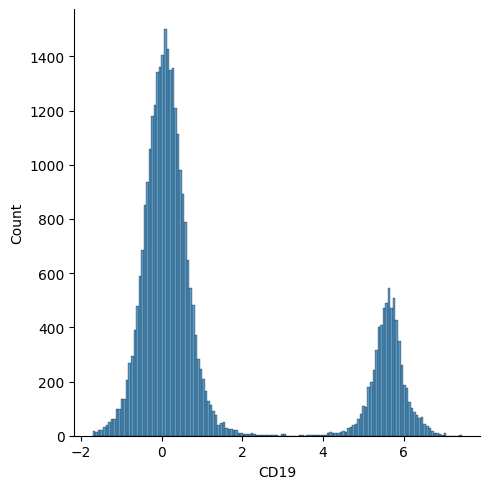

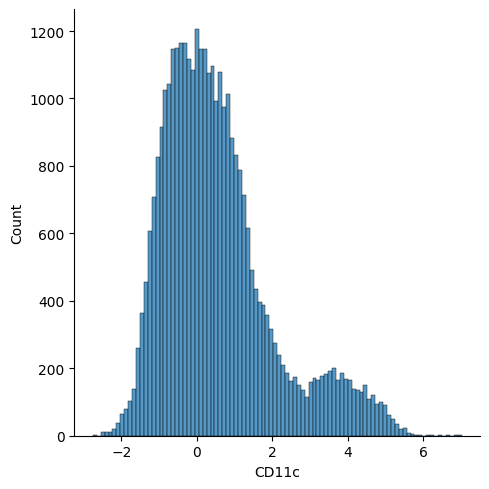

In [19]:
for col in df.columns[~df.columns.isin(['FSC-A', 'SSC-A'])] :
    sns.displot(df[col])

Видно, что все, кроме CD45, имеют бимодальное распределение, т.е. можно разделить клетки на две группы, где маркеры сильно экспрессированы и где практически отсуствует экспрессия. CD45 имеет унимодальное распределение, где большинство клеток имеют высокую экспрессию данного биомаркера. Возможно, что CD45 это маркер для всех трех типов клеток одновременно, но это посмотрим позже уже на этапе кластеризации

In [20]:
df.columns

Index(['FSC-A', 'SSC-A', 'HLA-DR', 'CD3', 'CD45', 'CD14', 'CD56', 'CD19',
       'CD11c'],
      dtype='object')

Также можно посмотреть как клетки разделяются на scatterplot, где в качестве координат будет использовать FSC-A, SSC-A

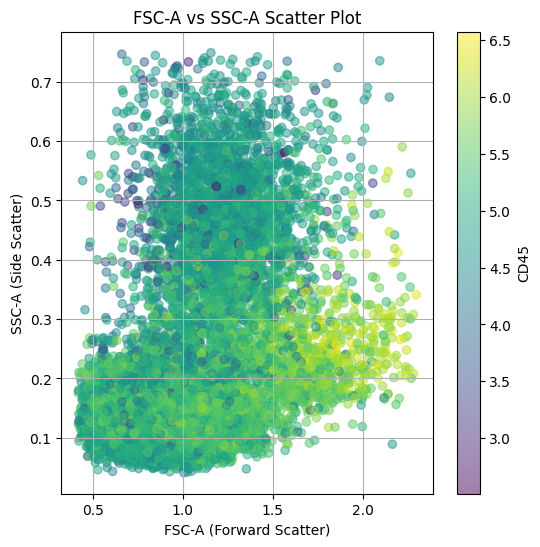

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
scatter = plt.scatter(df['FSC-A'], df['SSC-A'], alpha=0.5, c=df['CD45'])
plt.title('FSC-A vs SSC-A Scatter Plot')
plt.xlabel('FSC-A (Forward Scatter)')
plt.ylabel('SSC-A (Side Scatter)')
plt.colorbar(scatter, label='CD45')
plt.grid(True)
plt.show()

Теперь посмотрим на какую-то клетку с бимодальным распределением, к примеру, CD3. Видно, что можно отделить один кластер клеток, благодаря данному маркеру

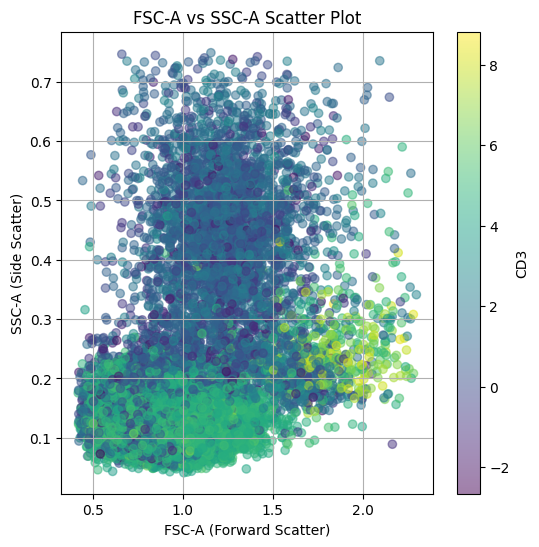

In [22]:
plt.figure(figsize=(6, 6))
scatter = plt.scatter(df['FSC-A'], df['SSC-A'], alpha=0.5, c=df['CD3'])
plt.title('FSC-A vs SSC-A Scatter Plot')
plt.xlabel('FSC-A (Forward Scatter)')
plt.ylabel('SSC-A (Side Scatter)')
plt.colorbar(scatter, label='CD3')
plt.grid(True)
plt.show()

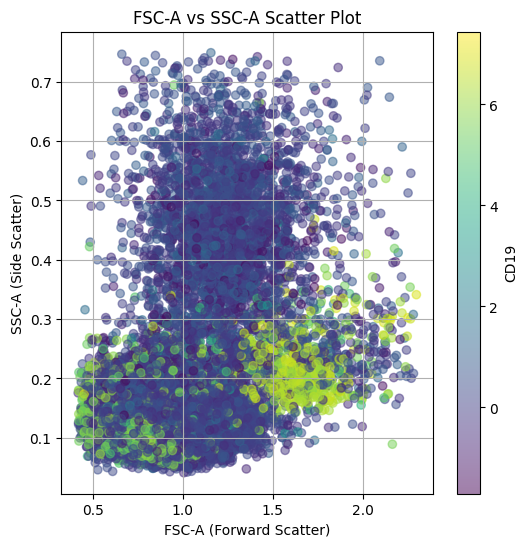

In [23]:
plt.figure(figsize=(6, 6))
scatter = plt.scatter(df['FSC-A'], df['SSC-A'], alpha=0.5, c=df['CD19'])
plt.title('FSC-A vs SSC-A Scatter Plot')
plt.xlabel('FSC-A (Forward Scatter)')
plt.ylabel('SSC-A (Side Scatter)')
plt.colorbar(scatter, label='CD19')
plt.grid(True)
plt.show()

Попытаемся убрать отрицательные значения по максимум, видно, что некоторые можно отфильтровать по нижнему квартилю. Верхний квартиль пока не трогаем, так как там наблюдается большое скопление наблюдений. Их мы сначала посмотрим на распределении

In [24]:
df.min(axis=0)

FSC-A     0.420182
SSC-A     0.041062
HLA-DR   -4.587832
CD3      -2.658754
CD45      2.509808
CD14     -0.586052
CD56     -1.044331
CD19     -1.708414
CD11c    -2.753734
dtype: float64

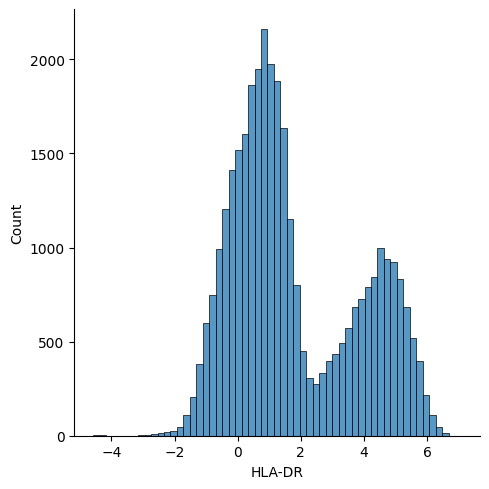

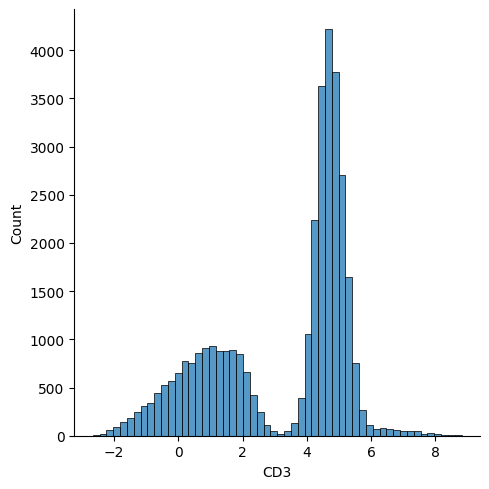

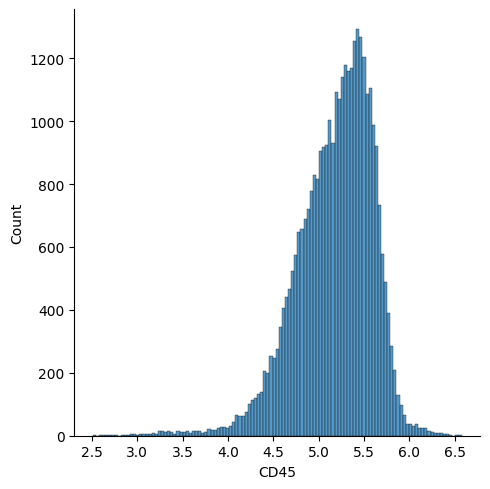

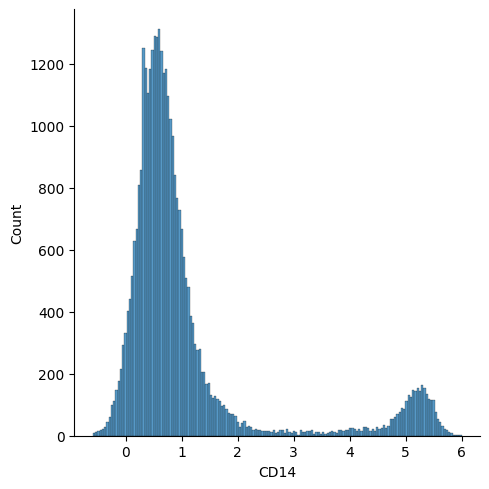

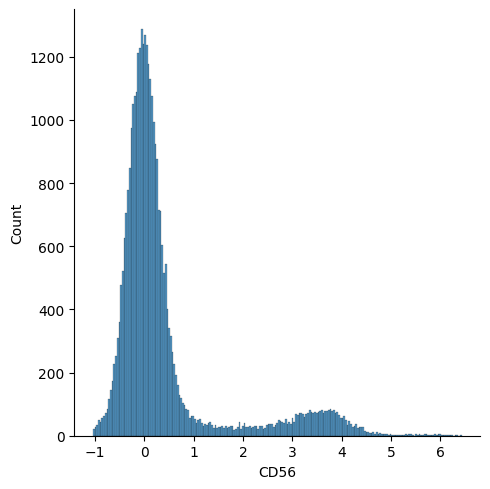

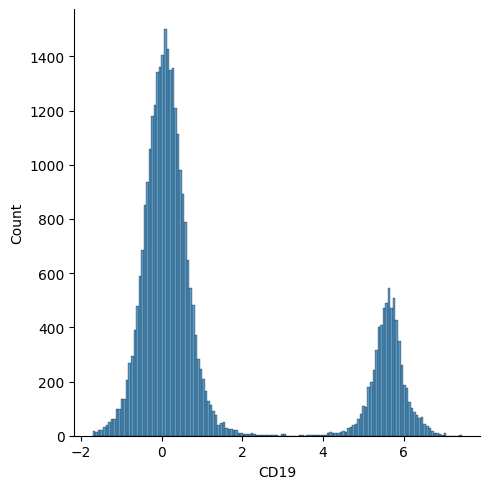

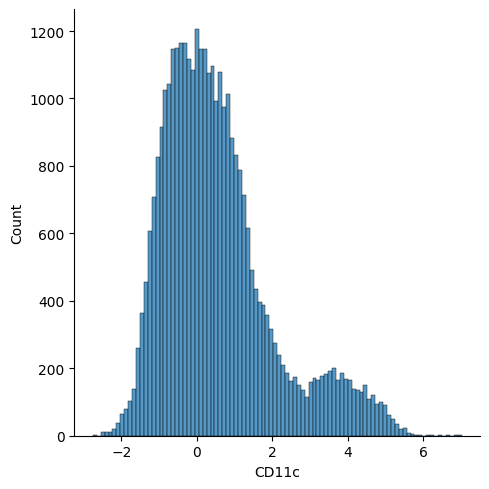

In [25]:
for col in df.columns[~df.columns.isin(['FSC-A', 'SSC-A'])]:
    sns.displot(df[col])

Мы можем наблюдать бимодальное распределение, HLA-DR, CD3, CD14, CD56, CD19, CD11c. Есть гипеотеза, что они могут помочь кластеризовать клетки успешнее, так как тут клетки разделяются на две группы (высоко экспресивнные и практически без экспресии). Для них стандартная фильтрация выбросов по mad deviation или z-score удалит также вторую группу клеток, так что вцелом оставим дальше эти распределения без изменений, так как видно из распределений сверху, что выбросов  практически не наблюдается

Выберем метод нормализации Arcsinh Transformation, так как у нас много отрицательных значений. Далее нам нужны лишь экспресии генов, поэтому уберем FSC-A, SSC-A из датасета. Таким образом кластеризация будет происходить лишь по функциональным особенностям клеток

In [42]:
df_final = df.loc[:, ~df.columns.isin(['FSC-A', 'SSC-A'])].copy()
df_final.head()

,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
6,3.523124,1.485025,4.788795,5.483128,-0.314870,1.000637,3.304998
7,4.921549,-1.726940,5.253668,0.333739,0.342336,5.876312,1.362900
11,4.981942,1.047433,5.358941,5.631640,0.155462,0.905064,4.506790
16,5.583107,4.706273,5.912384,0.882935,0.353881,5.494634,-1.550571
17,5.429337,2.404481,5.351980,3.329632,0.333889,1.306445,4.934134


<Axes: >

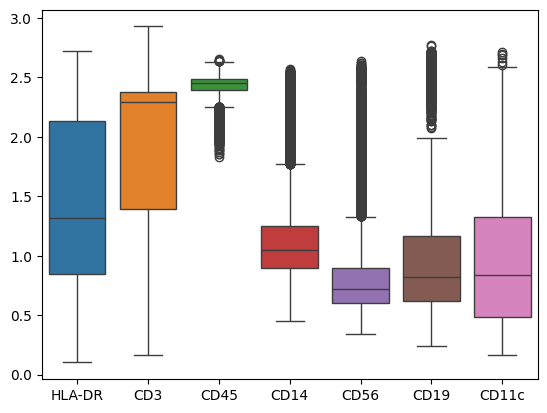

In [44]:
df_final = np.log1p(df_final + np.sqrt(df_final ** 2 + 1))
sns.boxplot(df_final)

In [45]:
df.shape

(34323, 9)

In [46]:
df_final.to_csv('./Task 5/preprocessed_data.tsv', index=True, sep='\t')

# Clustering

In [106]:
adata = sc.read_csv('./Task 5/preprocessed_data.tsv', delimiter='\t', first_column_names=True)
adata

AnnData object with n_obs × n_vars = 34323 × 7

<Axes: >

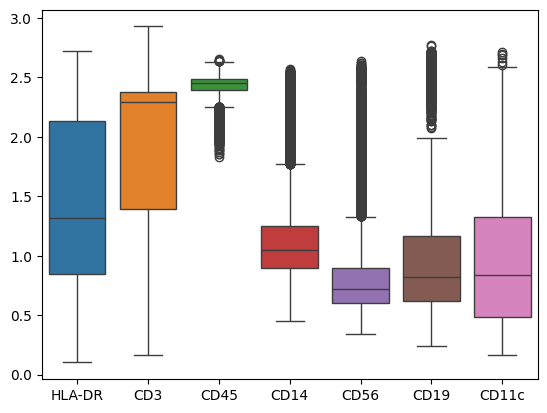

In [107]:
sns.boxplot(adata.to_df())

In [108]:
adata

AnnData object with n_obs × n_vars = 34323 × 7

1. Посчтиаем t-SNE координаты для каждой клетки

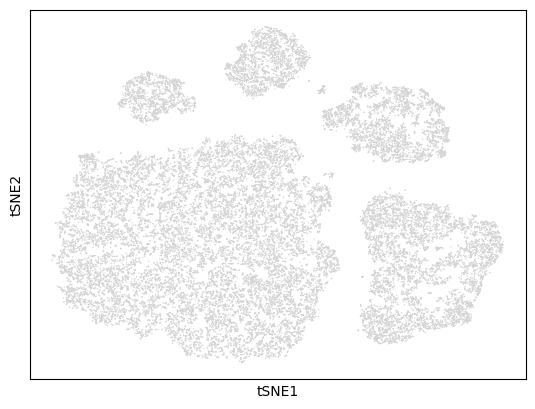

In [109]:
sc.tl.tsne(adata, n_pcs=2, perplexity=50)
sc.pl.tsne(adata)

In [110]:
adata.var_names

Index(['HLA-DR', 'CD3', 'CD45', 'CD14', 'CD56', 'CD19', 'CD11c'], dtype='object')

2. Сделать кластеризацию клеток

Сначала считаем матрицу дистанций ближайших соседей, так как она затем будет нужна для дальнейшей кластеризации. Тут я подбирал параметры, меняя их и смотря на результат. Не стал делать отдельные ячейки для этого

In [111]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=2)

In [112]:
sc.tl.leiden(
    adata,
    key_added="clusters",
    resolution=0.050,
    n_iterations=2,
    flavor="igraph",
    directed=False,
)

3. I. Отрисуем кластеры по tSNE координатам

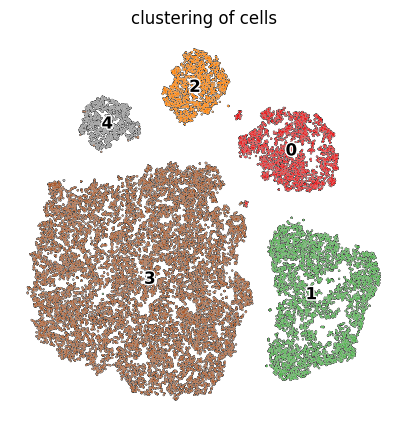

In [113]:
#3 Color by clusters
with rc_context({"figure.figsize": (5, 5)}):
    sc.pl.tsne(
        adata,
        color="clusters",
        add_outline=True,
        legend_loc="on data",
        legend_fontsize=12,
        legend_fontoutline=2,
        frameon=False,
        title="clustering of cells",
        palette="Set1",
    )

In [114]:
adata

AnnData object with n_obs × n_vars = 34323 × 7
    obs: 'clusters'
    uns: 'tsne', 'neighbors', 'clusters', 'clusters_colors'
    obsm: 'X_tsne'
    obsp: 'distances', 'connectivities'

3. II. Теперь отрисуем как распределились маркеры по кластерам

In [115]:
adata.var_names.to_list()

['HLA-DR', 'CD3', 'CD45', 'CD14', 'CD56', 'CD19', 'CD11c']

Для CD45, можно тут также заметить, что практически во всех кластерах он был имел высокую экспресию

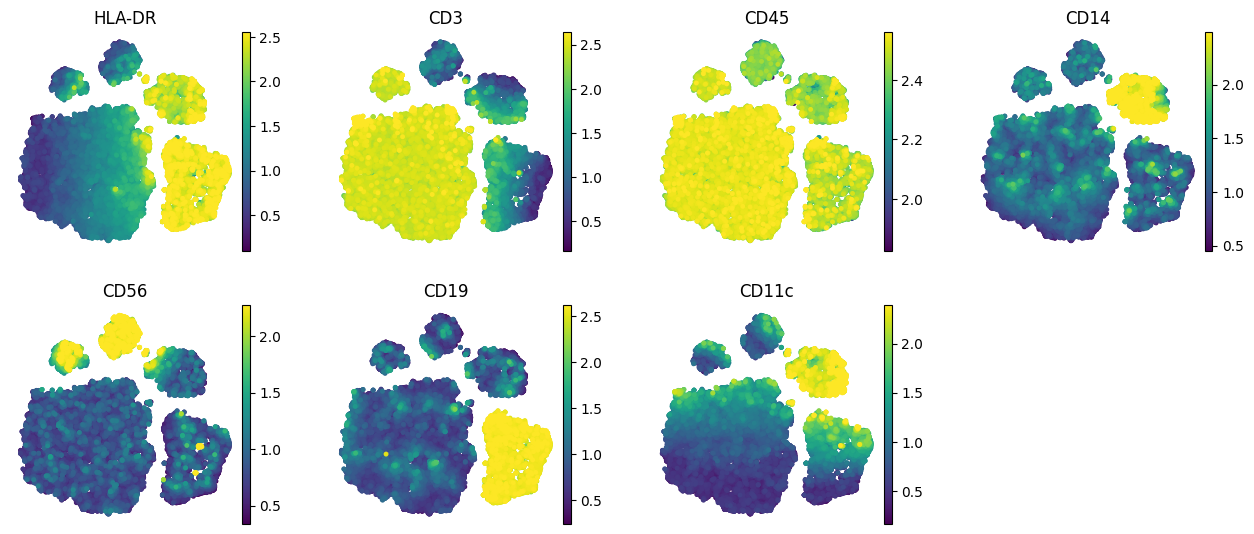

In [116]:
color_vars = adata.var_names.to_list()
with rc_context({"figure.figsize": (3, 3)}):
    sc.pl.tsne(adata, color=color_vars, s=50, frameon=False, ncols=4, vmax="p99")

5-6. Попробуем определить, где какие клетки. Подробное описание по маркерам я привел в гугл доке(). 
CD45 как и оказалось может быть экспресирована во всех трех типов клеток, поэтому в разделении она поможет только для определения, где есть наши искомые популяции клеток (T-cells, B-cells, Monocytes). CD3 маркер для T-cells, CD19 для B-cells. CD14, CD11c для моноцитов.

In [117]:
adata.var_names

Index(['HLA-DR', 'CD3', 'CD45', 'CD14', 'CD56', 'CD19', 'CD11c'], dtype='object')

In [118]:
marker_genes_dict = {
    "B-cell": ["HLA-DR", 'CD19'],
    "Monocytes": ["HLA-DR", 'CD14', 'CD11c'],
    "T-cell": ["CD3", 'CD56', 'CD45'],
    #"Other cell 1" : ['CD3'],
    #"Other cell 2" : ['CD3']
}

In [502]:
#sc.tl.dendrogram(adata, n_pcs=2, groupby='clusters')

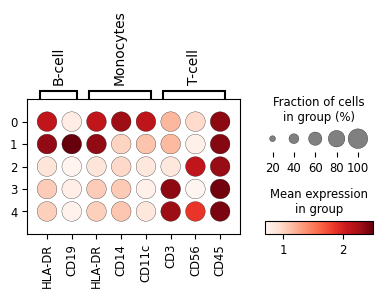

In [119]:
sc.pl.dotplot(adata, marker_genes_dict, "clusters", dendrogram=False)

CD-3 отделил кластера 3,4 как T-cells. CD19 отделил кластер 1 как B-cells. CD14, CD11c отделил калстер 0 как моноциты. Кластер 2 может быть как T-cells, так и other cells. Тут однозначно судить нельзя так как CD56 может быть экспрессирован не только в T-cells

In [120]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
    "0": "Monocytes",
    "1": "B-cells",
    "2": "Other_cells",
    "3": "T-cells",
    "4": "T-cells"
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs["Population"] = adata.obs["clusters"].map(cluster2annotation).astype("category")

categories: B-cells, Monocytes, Other_cells, etc.
var_group_labels: B-cell, Monocytes, T-cell


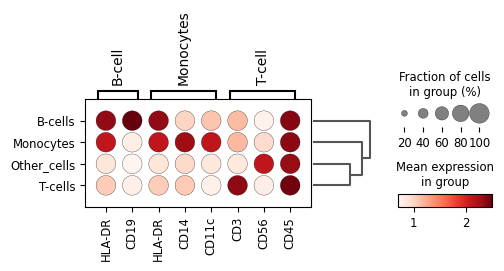

In [121]:
sc.pl.dotplot(adata, marker_genes_dict, "Population", dendrogram=True)

7. Ниже показаны отрисованные кластера клеток уже по именам

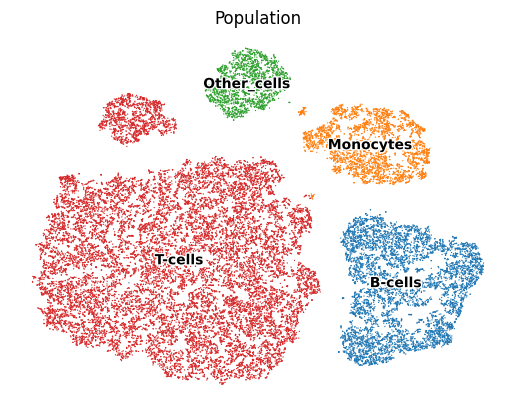

In [122]:
sc.pl.tsne(
    adata,
    color="Population",
    legend_loc="on data",
    frameon=False,
    legend_fontsize=10,
    legend_fontoutline=2,
)

In [123]:
adata.obs['Population']

6         Monocytes
7           B-cells
11        Monocytes
16          B-cells
17        Monocytes
            ...    
269272      T-cells
269281      T-cells
269283      T-cells
269285      T-cells
269286    Monocytes
Name: Population, Length: 34323, dtype: category
Categories (4, object): ['B-cells', 'Monocytes', 'Other_cells', 'T-cells']

In [124]:
adata.obs['Population'].value_counts()

Population
T-cells        21449
B-cells         6948
Monocytes       3662
Other_cells     2264
Name: count, dtype: int64

Теперь соединим текущее распределение клеток по популяциям с теми, что были отброшены на начальных этапах. Определим их в other cells

In [125]:
df_initial = pd.read_csv('./Task 5/test_data.tsv', sep='\t', index_col=0)
df_initial.head()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
6,1.501749,0.526060,3.523124,1.485025,4.788795,5.483128,-0.314870,1.000637,3.304998
7,0.848230,0.105850,4.921549,-1.726940,5.253668,0.333739,0.342336,5.876312,1.362900
11,1.546926,0.406637,4.981942,1.047433,5.358941,5.631640,0.155462,0.905064,4.506790
16,1.697505,0.291444,5.583107,4.706273,5.912384,0.882935,0.353881,5.494634,-1.550571
17,1.248090,0.245040,5.429337,2.404481,5.351980,3.329632,0.333889,1.306445,4.934134


In [126]:
df_initial.shape

(34812, 9)

In [128]:
df_with_cell_types = pd.DataFrame(adata.obs['Population'])
df_with_cell_types.index = df_with_cell_types.index.astype(np.int64)
df_with_cell_types.shape

(34323, 1)

In [134]:
df_clustered = df_initial.join(df_with_cell_types, how='left')
df_clustered.head()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c,Population
6,1.501749,0.526060,3.523124,1.485025,4.788795,5.483128,-0.314870,1.000637,3.304998,Monocytes
7,0.848230,0.105850,4.921549,-1.726940,5.253668,0.333739,0.342336,5.876312,1.362900,B-cells
11,1.546926,0.406637,4.981942,1.047433,5.358941,5.631640,0.155462,0.905064,4.506790,Monocytes
16,1.697505,0.291444,5.583107,4.706273,5.912384,0.882935,0.353881,5.494634,-1.550571,B-cells
17,1.248090,0.245040,5.429337,2.404481,5.351980,3.329632,0.333889,1.306445,4.934134,Monocytes


In [135]:
df_clustered['Population'].value_counts()

Population
T-cells        21449
B-cells         6948
Monocytes       3662
Other_cells     2264
Name: count, dtype: int64

In [136]:
df_clustered.shape

(34812, 10)

In [137]:
df_clustered.loc[df_clustered['Population'].isna(), 'Population'] = 'Other_cells'
df_clustered['Population'].value_counts()

Population
T-cells        21449
B-cells         6948
Monocytes       3662
Other_cells     2753
Name: count, dtype: int64

Сохраним распределение по популяциям в файл

In [138]:
df_clustered['Population'].to_csv('./Task 5/population.csv')